In [1]:
import scipy.stats
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# Read in csv file and print out the number of rows
df = pd.read_csv('GPTarget2024.csv')

# Filter select rows where condition = "microtargeting" or "control" or "no microtargeting"
df = df[(df['treatment_condition'] == 'microtargeting') | (df['treatment_condition'] == 'control')]

# make sure that a_0 is a column where the values are 1 if treatment_condition is control and 0 otherwise
df['a_0'] = np.where(df['treatment_condition'] == 'control', 1, 0)

# Create new dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]

In [3]:
# Define the formula for the model
formula = 'dv_response_mean ~ a_1 + a_3 + a_5 + a_7 + a_9 + political_party_coded + political_ideology_coded + political_engagement_coded'

# Fit the model for all issues 
model = smf.ols(formula, data=df)
result = model.fit(cov_type='HC3')

# Fit the model for digital privacy
model_digital_privacy = smf.ols(formula, data=df_digital_privacy)
result_digital_privacy = model_digital_privacy.fit(cov_type='HC3')

# Fit the model for renewable energy
model_renewable_energy = smf.ols(formula, data=df_renewable_energy)
result_renewable_energy = model_renewable_energy.fit(cov_type='HC3')

# Fit the model for china sanctions
model_china_sanctions = smf.ols(formula, data=df_china_sanctions)
result_china_sanctions = model_china_sanctions.fit(cov_type='HC3')

# Fit the model for nato support
model_nato_support = smf.ols(formula, data=df_nato_support)
result_nato_support = model_nato_support.fit(cov_type='HC3')

# Print the summary of the regression
print(result_digital_privacy.summary())

                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     12.08
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           7.63e-17
Time:                        09:57:31   Log-Likelihood:                -6559.0
No. Observations:                1502   AIC:                         1.314e+04
Df Residuals:                    1493   BIC:                         1.318e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [4]:
# Create a dataframe to store the results for plotting
issues_models = {
    'Renewable Energy': result_renewable_energy,
    'Digital Privacy': result_digital_privacy,
    'China Sanctions': result_china_sanctions,
    'NATO Support': result_nato_support
}

# Initialize an empty list to store the data
data = []

# Iterate over the dictionary to extract the data
for issue, model in issues_models.items():
    # Extract the coefficients and the confidence intervals
    coef = model.params
    conf_int = model.conf_int()
    
    # Iterate over the coefficients
    for covariate in ['a_1', 'a_3', 'a_5', 'a_7', 'a_9']:
        # Use the Q function label format
        q_covariate = f'{covariate}'
        # Skip if the covariate is not in the model
        if q_covariate not in coef:
            continue
        # Get the coefficient and confidence interval
        coefficient = coef[q_covariate]
        lower_ci, upper_ci = conf_int.loc[q_covariate]
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue': issue,
            'Coefficient': coefficient,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

In [5]:
# Compute and append precision-weighted means and confidence intervals to the results DataFrame
models = [result_renewable_energy, result_digital_privacy, result_china_sanctions, result_nato_support]

def compute_weighted_stats(term, models):
    coefficients = np.array([model.params[term] for model in models])
    standard_errors = np.array([model.bse[term] for model in models])

    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)

    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)

    return weighted_mean, weighted_std_error, confidence_interval

# Compute for 'a_1', 'a_3', 'a_5', 'a_7', 'a_9'
a_1_mean, a_1_se, a_1_ci = compute_weighted_stats('a_1', models)
a_3_mean, a_3_se, a_3_ci = compute_weighted_stats('a_3', models)
a_5_mean, a_5_se, a_5_ci = compute_weighted_stats('a_5', models)
a_7_mean, a_7_se, a_7_ci = compute_weighted_stats('a_7', models)
a_9_mean, a_9_se, a_9_ci = compute_weighted_stats('a_9', models)

# Create a list of dictionaries for the new rows including the standard error
weighted_stats = [
    {'Covariate': 'a_1', 'Issue': 'Precision-weighted Mean', 'Coefficient': a_1_mean, 'SE': a_1_se, '95% CI Lower': a_1_ci[0], '95% CI Upper': a_1_ci[1]},
    {'Covariate': 'a_3', 'Issue': 'Precision-weighted Mean', 'Coefficient': a_3_mean, 'SE': a_3_se, '95% CI Lower': a_3_ci[0], '95% CI Upper': a_3_ci[1]},
    {'Covariate': 'a_5', 'Issue': 'Precision-weighted Mean', 'Coefficient': a_5_mean, 'SE': a_5_se, '95% CI Lower': a_5_ci[0], '95% CI Upper': a_5_ci[1]},
    {'Covariate': 'a_7', 'Issue': 'Precision-weighted Mean', 'Coefficient': a_7_mean, 'SE': a_7_se, '95% CI Lower': a_7_ci[0], '95% CI Upper': a_7_ci[1]},
    {'Covariate': 'a_9', 'Issue': 'Precision-weighted Mean', 'Coefficient': a_9_mean, 'SE': a_9_se, '95% CI Lower': a_9_ci[0], '95% CI Upper': a_9_ci[1]},
]

# Convert the list of dictionaries to a DataFrame
weighted_stats_df = pd.DataFrame(weighted_stats)

# Append the new DataFrame to the existing results_df
results_df = results_df.append(weighted_stats_df, ignore_index=True)

# Add a new row to results_df for best message condition
results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'Precision-weighted Mean', 'Coefficient': 6.20, '95% CI Lower': 4.49, '95% CI Upper': 7.90}, ignore_index=True)
results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'Renewable Energy', 'Coefficient': 1.10, '95% CI Lower': -1.93, '95% CI Upper': 4.07}, ignore_index=True)
results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'Digital Privacy', 'Coefficient': 6.37, '95% CI Lower': 3.00, '95% CI Upper': 9.73}, ignore_index=True)
results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'China Sanctions', 'Coefficient': 11.94, '95% CI Lower': 8.10, '95% CI Upper': 15.79}, ignore_index=True)
results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'NATO Support', 'Coefficient': 8.37, '95% CI Lower': 4.79, '95% CI Upper': 11.94}, ignore_index=True)


/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_3089/3298572442.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(weighted_stats_df, ignore_index=True)
/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_3089/3298572442.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'Precision-weighted Mean', 'Coefficient': 6.20, '95% CI Lower': 4.49, '95% CI Upper': 7.90}, ignore_index=True)
/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_3089/3298572442.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Covariate': '0 (Best Message)', 'Issue': 'Renewable Energy', 

In [6]:
def z_test(mean1, se1, mean2, se2):
    # Calculate the difference in means
    mean_diff = mean1 - mean2
    # Calculate the standard error of the difference
    se_diff = np.sqrt(se1**2 + se2**2)
    # Calculate the z-statistic
    z_stat = mean_diff / se_diff
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    return z_stat, p_value

# Define a function to perform the z-test and print the results
def compare_means(mean1, se1, mean2, se2, label1, label2):
    z_stat, p_value = z_test(mean1, se1, mean2, se2)
    if p_value < 0.05:
        print(f"Comparison between {label1} and {label2} IS statistically significant (Z-statistic: {z_stat:.3f}, P-value: {p_value:.3f})")
    else:
        print(f"Comparison between {label1} and {label2} is not statistically significant (Z-statistic: {z_stat:.3f}, P-value: {p_value:.3f})")

# Create a list of tuples with the means, standard errors, and labels
comparisons = [
    (a_1_mean, a_1_se, a_9_mean, a_9_se, 'a_1', 'a_9')
]

# Iterate over the comparisons and perform the z-test
for mean1, se1, mean2, se2, label1, label2 in comparisons:
    compare_means(mean1, se1, mean2, se2, label1, label2)

Comparison between a_1 and a_9 is not statistically significant (Z-statistic: -0.247, P-value: 0.805)


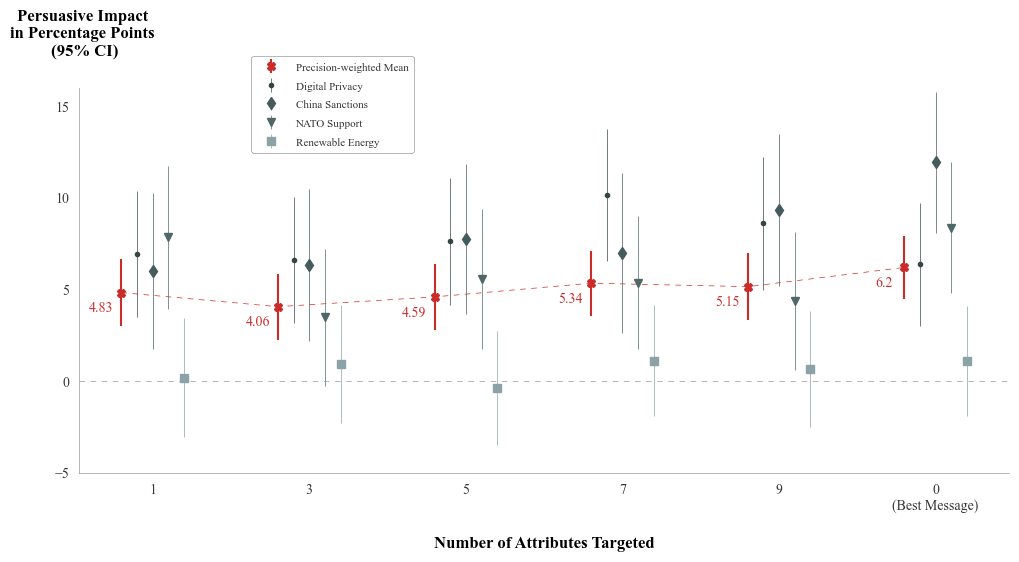

In [7]:
#FIGURE 3
# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Define constants
LABELS = ["Precision-weighted Mean", "Digital Privacy", "China Sanctions", "NATO Support", "Renewable Energy"]
COLOR_MAP = ['#CB2C2A', '#354546', '#465B5D', '#4F6769', '#8BA3A7']
MARKERS = ['X', '.', 'd', 'v', 's']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(12,5))

# Use floating point numbers for the x_pos array
covariates = results_df['Covariate'].unique()
x_pos = np.arange(len(covariates), dtype=float) - len(LABELS)/2 * 0.1

for label, color, marker in zip(LABELS, COLOR_MAP, MARKERS):
    # Filter the dataframe for the current issue
    df_issue = results_df[results_df['Issue'] == label]
    
    # Ensure the covariates are in the correct order
    df_issue = df_issue.set_index('Covariate').loc[covariates].reset_index()
    
    # Plot coefficients with error bars and add coefficient labels
    eb = ax.errorbar(x_pos + 0.05, df_issue['Coefficient'], 
                yerr=(df_issue['Coefficient'] - df_issue['95% CI Lower'], df_issue['95% CI Upper'] - df_issue['Coefficient']), 
                fmt=marker, color=color, ecolor=color, capsize=0, label=label)

    # Change linewidth of error bars for non 'Precision-weighted Mean' labels
    if label != 'Precision-weighted Mean':
        eb[-1][0].set_linewidth(0.5)  # Here '-1' is used to access the error bar line collection
    
    # Connect points with dashed line for 'Precision-weighted Mean' only
    if label == 'Precision-weighted Mean':
        ax.plot(x_pos + 0.05, df_issue['Coefficient'], color=color, linestyle='dashed', linewidth=0.5, dashes=(8, 8))

    # Add labels below the 'Precision-weighted Mean' dots
    if label == 'Precision-weighted Mean':
        for i, coef in enumerate(df_issue['Coefficient']):
            ax.text(x_pos[i] - 0.08, coef - .85, round(coef, 2), 
                    va='center', ha='center', color=color, 
                    bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

    # Update x_pos for next plot
    x_pos += 0.1

# Configure the plot
plt.axhline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(8, 8))
plt.ylim(-5, 16)

ax.text(-.45, 18.9, 'Persuasive Impact\nin Percentage Points\n (95% CI)', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Attributes Targeted', fontsize=12, fontweight='bold', labelpad=17)
ax.set_xticks(np.arange(len(covariates)))
ax.set_xticklabels([1, 3, 5, 7, 9, "0\n(Best Message)"], rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(colors='#333333')
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(loc=(0.185, 0.830), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

# Save the figure as a PDF
fig.savefig('figure3.pdf', format='pdf', bbox_inches='tight')